## Step 0: Enviroment setting

In [1]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
cudf 23.4.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.19.6 which is incompatible.
beatrix-jupyter

In [1]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


## Step 1: Load the dataset files

In [2]:
dataset_root = '/kaggle/input/kermany2018/OCT2017 ' 
train_dir = os.path.join(dataset_root, 'train')
val_dir = os.path.join(dataset_root, 'val')
test_dir = os.path.join(dataset_root, 'test')

## Step 2: Create training datasets

In [3]:
# Define data generator 

seed = 10

train_datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator()

In [4]:
train_ds = train_datagen.flow_from_directory(train_dir, 
                                             target_size=(224,224),
                                             subset='training',
                                             seed=seed,
                                             class_mode="categorical")

Found 66788 images belonging to 4 classes.


In [5]:
val_ds = train_datagen.flow_from_directory(train_dir, 
                                           target_size=(224,224),
                                           subset='validation',
                                           seed=seed,
                                           class_mode="categorical")

Found 16696 images belonging to 4 classes.


In [6]:
test_ds = test_datagen.flow_from_directory(test_dir, 
                                             target_size=(224,224),
                                             class_mode="categorical")

Found 968 images belonging to 4 classes.


## Step 3: Visualizations

In [8]:
def view_image(ds):
    image, label = next(iter(ds))
    image = image 
    label = label 

    fig = plt.figure(figsize=(22, 22))
    for i in range(4):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].astype(np.int32))

        # Determine the position of the 1 in the label array
        position = np.where(label[i] == 1)[0][0]

        # Assign the corresponding name based on the position
        if position == 0:
            name = 'CNV'
        elif position == 1:
            name = 'DME'
        elif position == 2:
            name = 'DRUSEN'
        elif position == 3:
            name = 'NORMAL'
        else:
            name = 'Unknown'
        ax.set_title(f"Label: {name}")

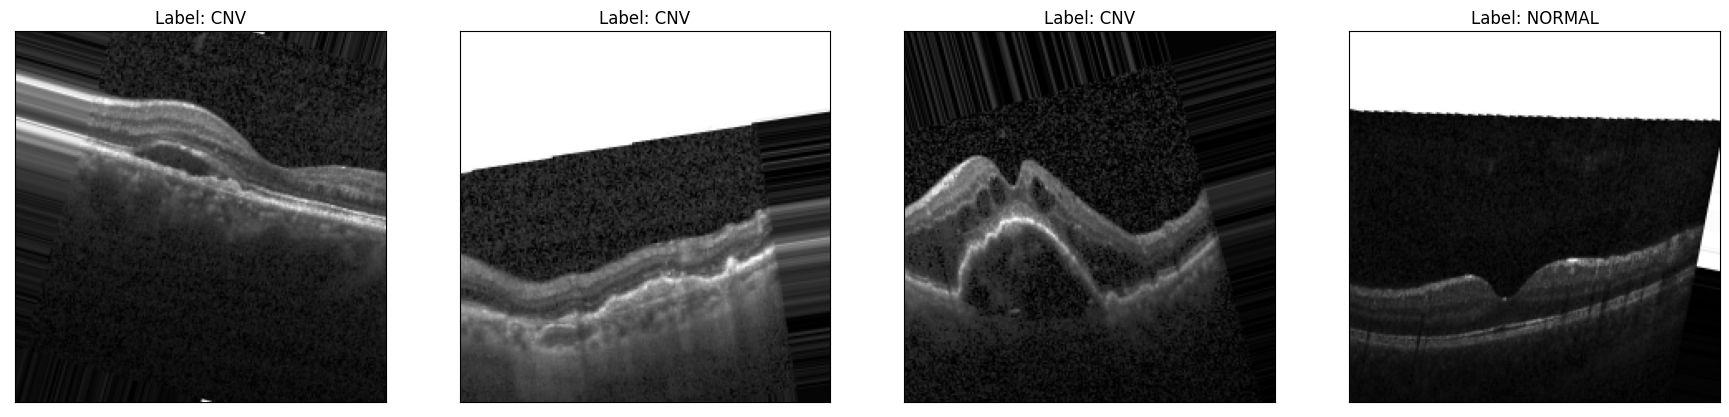

In [9]:
view_image(train_ds)

## Step 4: Model Creation

In [10]:
def create_model(input_shape=(224,224,3),output_units=4):
    
    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(input_shape)
    pool = tf.keras.layers.GlobalAveragePooling2D()
    flatten = tf.keras.layers.Flatten()
    softmax = tf.keras.layers.Dense(output_units, activation='softmax')
    
    x = inputs
    x = preprocess(x)
    x = base_model(x)
    x = pool(x)
    x = flatten(x)
    out = softmax(x)
    
    return tf.keras.Model(inputs=inputs, outputs=out)

## Metric tracker

In [11]:
# Define custom metrics
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_val

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_val = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_val

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_val = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    return f1_val

# Define metrics list
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score]

## Step 5: Train model on the full dataset

## Step 5a: Base model layers frozen

In [12]:
resnet_full = create_model()

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
            tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.{epoch:02d}-{val_loss:.2f}.h5')]

resnet_full.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

In [13]:
resnet_full_history = resnet_full.fit(train_ds,
                                   validation_data=val_ds,
                                   callbacks=callbacks,
                                   epochs=20)

94668760/94668760 [==============================] - 4s 0us/step
Epoch 1/20
2088/2088 [==============================] - 1567s 746ms/step - loss: 0.5348 - accuracy: 0.8049 - precision: 0.8459 - recall: 0.7624 - f1_score: 0.8002 - val_loss: 0.4333 - val_accuracy: 0.8435 - val_precision: 0.8727 - val_recall: 0.8140 - val_f1_score: 0.8418
Epoch 2/20
2088/2088 [==============================] - 1204s 576ms/step - loss: 0.4528 - accuracy: 0.8357 - precision: 0.8628 - recall: 0.8087 - f1_score: 0.8343 - val_loss: 0.4275 - val_accuracy: 0.8429 - val_precision: 0.8753 - val_recall: 0.8116 - val_f1_score: 0.8417
Epoch 3/20
2088/2088 [==============================] - 1209s 579ms/step - loss: 0.4374 - accuracy: 0.8426 - precision: 0.8677 - recall: 0.8182 - f1_score: 0.8418 - val_loss: 0.4458 - val_accuracy: 0.8474 - val_precision: 0.8682 - val_recall: 0.8287 - val_f1_score: 0.8477
Epoch 4/20
2088/2088 [==============================] - 1225s 587ms/step - loss: 0.4256 - accuracy: 0.8480 - precisi

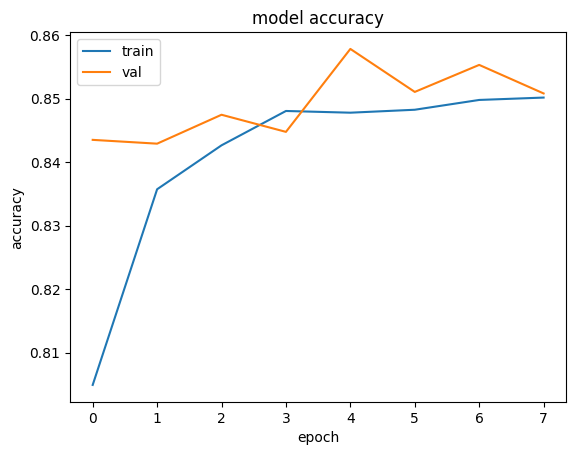

In [14]:
#plot accuracy

plt.plot(resnet_full_history.history['accuracy'])
plt.plot(resnet_full_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

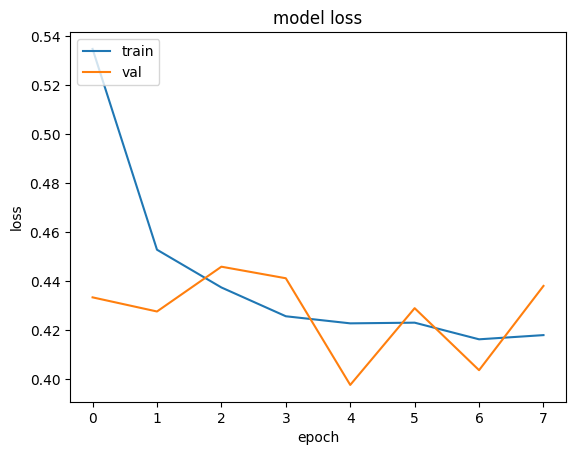

In [15]:
# Plot losses

plt.plot(resnet_full_history.history['loss'])
plt.plot(resnet_full_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Train on test dataset 
resnet_full.evaluate(test_ds)

31/31 [==============================] - 11s 345ms/step - loss: 0.3406 - accuracy: 0.8688 - precision: 0.8771 - recall: 0.8626 - f1_score: 0.8726


[0.3405592739582062,
 0.8688016533851624,
 0.8771008253097534,
 0.8626033067703247,
 0.8726345300674438]

## Step 5b: Base model layers unfrozen - Fine-tuning

In [13]:
resnet_full.trainable = True 

optimizer = tf.keras.optimizers.Adam(lr=1e-5)

resnet_full.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)


In [17]:
resnet_full_ft_history = resnet_full.fit(train_ds,
                                   validation_data=val_ds,
                                   callbacks=callbacks,
                                   epochs=20)

Epoch 1/20
2088/2088 [==============================] - 1496s 701ms/step - loss: 0.3010 - accuracy: 0.9020 - precision: 0.9118 - recall: 0.8900 - f1_score: 0.9005 - val_loss: 0.2817 - val_accuracy: 0.9138 - val_precision: 0.9192 - val_recall: 0.9078 - val_f1_score: 0.9133
Epoch 2/20
2088/2088 [==============================] - 1314s 629ms/step - loss: 0.2151 - accuracy: 0.9281 - precision: 0.9333 - recall: 0.9231 - f1_score: 0.9281 - val_loss: 0.7369 - val_accuracy: 0.8955 - val_precision: 0.9075 - val_recall: 0.8848 - val_f1_score: 0.8958
Epoch 3/20
2088/2088 [==============================] - 1324s 634ms/step - loss: 0.2237 - accuracy: 0.9268 - precision: 0.9321 - recall: 0.9218 - f1_score: 0.9268 - val_loss: 0.1981 - val_accuracy: 0.9365 - val_precision: 0.9419 - val_recall: 0.9314 - val_f1_score: 0.9365
Epoch 4/20
2088/2088 [==============================] - 1271s 609ms/step - loss: 0.1791 - accuracy: 0.9415 - precision: 0.9447 - recall: 0.9380 - f1_score: 0.9412 - val_loss: 0.6240

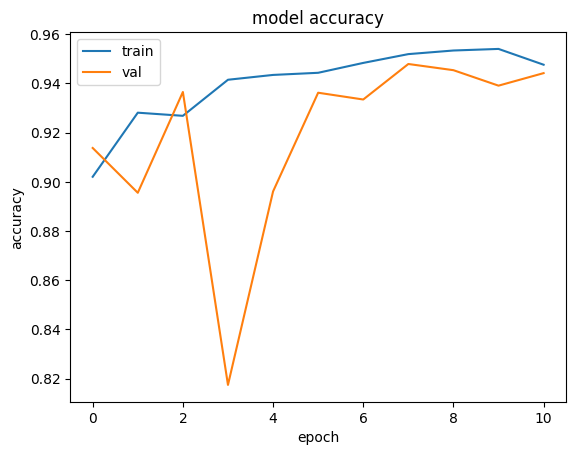

In [18]:
#plot accuracy

plt.plot(resnet_full_ft_history.history['accuracy'])
plt.plot(resnet_full_ft_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

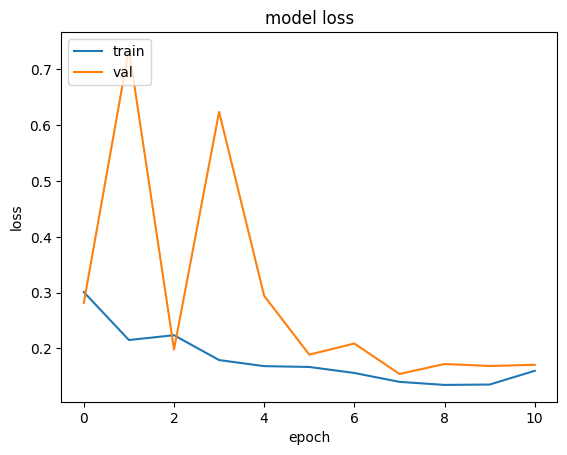

In [19]:
# Plot losses

plt.plot(resnet_full_ft_history.history['loss'])
plt.plot(resnet_full_ft_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# Train on test dataset 
resnet_full.evaluate(test_ds)

31/31 [==============================] - 8s 263ms/step - loss: 0.0370 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - f1_score: 0.9940


[0.037018269300460815,
 0.9938016533851624,
 0.9938016533851624,
 0.9938016533851624,
 0.9939516186714172]

In [14]:
resnet_full.load_weights('resnet_model.11-0.17.h5')

In [15]:
resnet_full.evaluate(test_ds)

31/31 [==============================] - 64s 2s/step - loss: 0.0370 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - f1_score: 0.9940


[0.037018273025751114,
 0.9938016533851624,
 0.9938016533851624,
 0.9938016533851624,
 0.9939516186714172]